# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2)
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 140645081777424, uid=head, address=CC2416, port=3016, state=listening>
MONITOR         Listening at <CommsManager object at 140645126987280, uid=monitor, address=CC2416, port=3030, state=listening>
WAREHOUSE       Listening at <CommsManager object at 140645126745680, uid=warehouse, address=CC2416, port=3031, state=listening>
NODE:0          Listening at <CommsManager object at 140645126622992, uid=node:0, address=CC2416, port=3032, state=listening>
WORKER:0:0      Listening at <CommsManager object at 140645126701392, uid=worker:0:0, address=CC2416, port=3033, state=listening>
WORKER:0:1      Listening at <CommsManager object at 140645126512720, uid=worker:0:1, address=CC2416, port=3034, state=listening>


## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.08e-6, num=2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

<IPython.core.display.Javascript object>


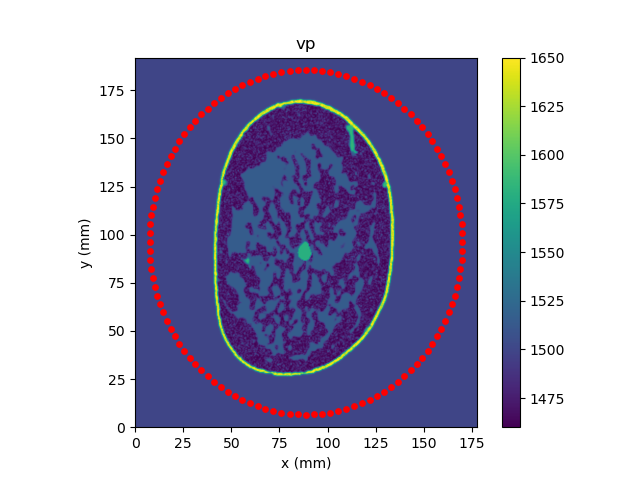

<IPython.core.display.Javascript object>


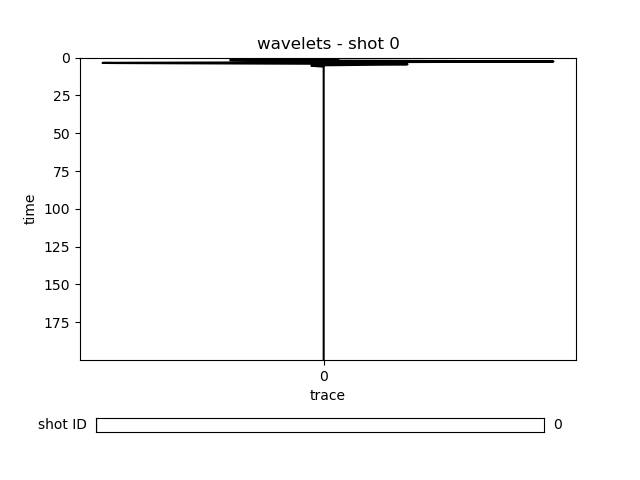

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
WORKER:0:0      Default Devito configuration:
WORKER:0:0      	 * autotuning=['aggressive', 'runtime']
WORKER:0:0      	 * develop-mode=False
WORKER:0:0      	 * mpi=False
WORKER:0:0      	 * log-level=DEBUG
WORKER:0:0      	 * language=openmp
WORKER:0:1      Default Devito configuration:
WORKER:0:1      	 * autotuning=['aggressive', 'runtime']
WORKER:0:1      	 * develop-mode=False
WORKER:0:1      	 * mpi=False
WORKER:0:1      	 * log-level=DEBUG
WORKER:0:1      	 * language=openmp
WORKER:0:0      (ShotID 0) Preparing to run state for shot
WORKER:0:1      (ShotID 1) Preparing to run state for shot
WORKER:0:0      (ShotID 0) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 0) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs

HEAD            Shot 3 retrieved
HEAD            Retrieved traces for shot 3
HEAD            Giving shot 5 to worker:0:1
WORKER:0:1      (ShotID 5) Preparing to run state for shot
WORKER:0:1      (ShotID 5) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 5) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 5) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 5) Selected undersampling level 4
WORKER:0:1      (ShotID 5) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 5) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.39 s
WORKER:0:0      Global performance: [OI=0.01, 14.85 GFlops/s, 0.40 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.99 s [OI=0.01, 20.76 GFlops/s, 0.56 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.03 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.67 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 9) Completed state equation run for shot
HEAD            Shot 9 retrieved
HEAD            Retrieved traces for shot 9
HEAD            Giving shot 11 to worker:0:1
WORKER:0:1      (ShotID 11) Preparing to run state for shot
WORKER:0:1      (ShotID 11) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 11) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 

WORKER:0:0      (ShotID 16) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 16) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 16) Selected undersampling level 4
WORKER:0:0      (ShotID 16) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 16) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.51 s
WORKER:0:1      Global performance: [OI=0.01, 13.62 GFlops/s, 0.37 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.44 s [OI=0.01, 14.27 GFlops/s, 0.39 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.06 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.12 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 20) Completed state equation run for shot
HEAD            Shot 20 retrieved
HEAD            Retrieved traces for shot 20
HEAD            Giving shot 22 to worker:0:0
WORKER:0:0      (ShotID 22) Preparing to run state for shot
WORKER:0:0      (ShotID 22) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 22) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 22) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 22) Selected undersampling level 4
WORKER:0:0      (ShotID 22) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 22) Running state equation for shot
WORKER:0:0      AutoTuner: c

WORKER:0:1      (ShotID 27) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 27) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.34 s
WORKER:0:0      Global performance: [OI=0.01, 15.32 GFlops/s, 0.42 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.29 s [OI=0.01, 15.95 GFlops/s, 0.43 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.04 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.77 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 26) Completed state equation run for shot
HEAD            Shot 26 retrieved
HEAD            Retrieved traces for shot 2

WORKER:0:1      (ShotID 31) Completed state equation run for shot
HEAD            Shot 31 retrieved
HEAD            Retrieved traces for shot 31
HEAD            Giving shot 33 to worker:0:1
WORKER:0:1      (ShotID 33) Preparing to run state for shot
WORKER:0:1      (ShotID 33) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 33) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 33) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 33) Selected undersampling level 4
WORKER:0:1      (ShotID 33) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 33) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.85 s
WORKER:0:0      Global performance: [OI=0.01, 24.29 GFlops/s, 0.66 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499

WORKER:0:1      Global performance: [OI=0.01, 15.57 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.28 s [OI=0.01, 16.05 GFlops/s, 0.44 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.03 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.72 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 37) Completed state equation run for shot
HEAD            Shot 37 retrieved
HEAD            Retrieved traces for shot 37
HEAD            Giving shot 39 to worker:0:1
WORKER:0:1      (ShotID 39) Preparing to run state for shot
WORKER:0:1      (ShotID 39) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 39) Spatial gr

WORKER:0:0      (ShotID 44) Preparing to run state for shot
WORKER:0:0      (ShotID 44) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 44) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 44) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 44) Selected undersampling level 4
WORKER:0:0      (ShotID 44) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 44) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.31 s
WORKER:0:1      Global performance: [OI=0.01, 15.76 GFlops/s, 0.43 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.28 s [OI=0.01, 16.14 GFlops/s, 0.44 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.55 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 48) Completed state equation run for shot
HEAD            Shot 48 retrieved
HEAD            Retrieved traces for shot 48
HEAD            Giving shot 50 to worker:0:0
WORKER:0:0      (ShotID 50) Preparing to run state for shot
WORKER:0:0      (ShotID 50) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 50) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 50) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 50) Selected undersampling level 4
WORKER:0:0      (ShotID

WORKER:0:1      (ShotID 55) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 55) Selected undersampling level 4
WORKER:0:1      (ShotID 55) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 55) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.10 s
WORKER:0:0      Global performance: [OI=0.01, 18.73 GFlops/s, 0.51 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.06 s [OI=0.01, 19.38 GFlops/s, 0.53 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.03 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.24 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaff

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 59) Completed state equation run for shot
HEAD            Shot 59 retrieved
HEAD            Retrieved traces for shot 59
HEAD            Giving shot 61 to worker:0:1
WORKER:0:1      (ShotID 61) Preparing to run state for shot
WORKER:0:1      (ShotID 61) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 61) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 61) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 61) Selected undersampling level 4
WORKER:0:1      (ShotID 61) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 61) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.08 s
WORKER:0:0      Global performance: [OI=0.01, 19.

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.03 s
WORKER:0:1      Global performance: [OI=0.01, 19.99 GFlops/s, 0.54 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.02 s [OI=0.01, 20.30 GFlops/s, 0.55 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.79 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 65) Completed state equation run for shot
HEAD            Shot 65 retrieved
HEAD            Retrieved traces for shot 65
HEAD            Giving shot 67 to worker:0:1
WORKER:0:1      (ShotID 67) Preparing to run state for shot
WORKER:0:1     

HEAD            Retrieved traces for shot 70
HEAD            Giving shot 72 to worker:0:0
WORKER:0:0      (ShotID 72) Preparing to run state for shot
WORKER:0:0      (ShotID 72) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 72) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 72) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 72) Selected undersampling level 4
WORKER:0:0      (ShotID 72) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 72) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.93 s
WORKER:0:1      Global performance: [OI=0.01, 22.14 GFlops/s, 0.60 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.92 s [OI=0.01, 22.36 GFl

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.95 s [OI=0.01, 21.67 GFlops/s, 0.59 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.73 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 76) Completed state equation run for shot
HEAD            Shot 76 retrieved
HEAD            Retrieved traces for shot 76
HEAD            Giving shot 78 to worker:0:0
WORKER:0:0      (ShotID 78) Preparing to run state for shot
WORKER:0:0      (ShotID 78) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 78) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm

WORKER:0:0      (ShotID 83) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 83) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 83) Selected undersampling level 4
WORKER:0:0      (ShotID 83) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 83) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.03 s
WORKER:0:1      Global performance: [OI=0.01, 19.94 GFlops/s, 0.54 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.02 s [OI=0.01, 20.25 GFlops/s, 0.55 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.66 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 87) Completed state equation run for shot
HEAD            Shot 87 retrieved
HEAD            Retrieved traces for shot 87
HEAD            Giving shot 89 to worker:0:0
WORKER:0:0      (ShotID 89) Preparing to run state for shot
WORKER:0:0      (ShotID 89) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 89) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 89) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 89) Selected undersampling level 4
WORKER:0:0      (ShotID 89) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 89) Running state equation for shot
WORKER:0:0      AutoTuner: c

WORKER:0:1      (ShotID 94) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 94) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.09 s
WORKER:0:0      Global performance: [OI=0.01, 18.93 GFlops/s, 0.51 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.07 s [OI=0.01, 19.19 GFlops/s, 0.52 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.10 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 93) Completed state equation run for shot
HEAD            Shot 93 retrieved
HEAD            Retrieved traces for shot 9

WORKER:0:1      (ShotID 98) Completed state equation run for shot
HEAD            Shot 98 retrieved
HEAD            Retrieved traces for shot 98
HEAD            Giving shot 100 to worker:0:1
WORKER:0:1      (ShotID 100) Preparing to run state for shot
WORKER:0:1      (ShotID 100) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 100) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 100) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 100) Selected undersampling level 4
WORKER:0:1      (ShotID 100) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 100) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.03 s
WORKER:0:0      Global performance: [OI=0.01, 20.02 GFlops/s, 0.54 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * sectio

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 104) Completed state equation run for shot
HEAD            Shot 104 retrieved
HEAD            Retrieved traces for shot 104
HEAD            Giving shot 106 to worker:0:1
WORKER:0:1      (ShotID 106) Preparing to run state for shot
WORKER:0:0      (ShotID 105) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 105) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 105) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 105) Selected undersampling level 4
WORKER:0:0      (ShotID 105) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 105) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 106) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER

HEAD            Giving shot 111 to worker:0:0
WORKER:0:0      (ShotID 111) Preparing to run state for shot
WORKER:0:0      (ShotID 111) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 111) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 111) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 111) Selected undersampling level 4
WORKER:0:0      (ShotID 111) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 111) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.19 s
WORKER:0:1      Global performance: [OI=0.01, 17.38 GFlops/s, 0.47 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.18 s [OI=0.01, 17.54 GFlops/s, 0.48 GPts/s]
WORKER:0:1       

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.94 s [OI=0.01, 21.87 GFlops/s, 0.59 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.05 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 115) Completed state equation run for shot
HEAD            Shot 115 retrieved
HEAD            Retrieved traces for shot 115
HEAD            Giving shot 117 to worker:0:0
WORKER:0:0      (ShotID 117) Preparing to run state for shot
WORKER:0:0      (ShotID 117) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 117) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0

<IPython.core.display.Javascript object>


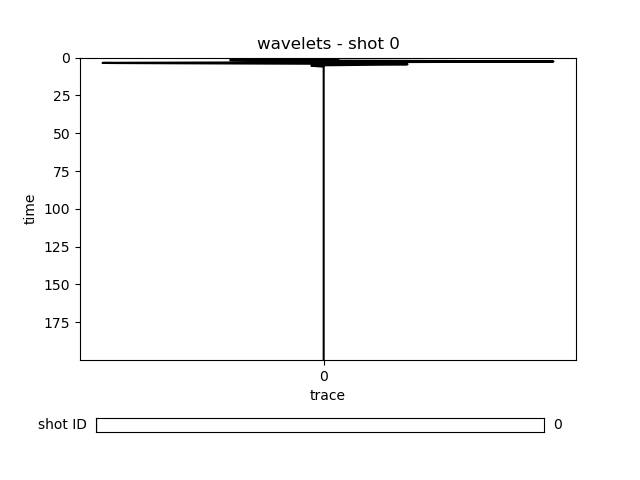

<IPython.core.display.Javascript object>


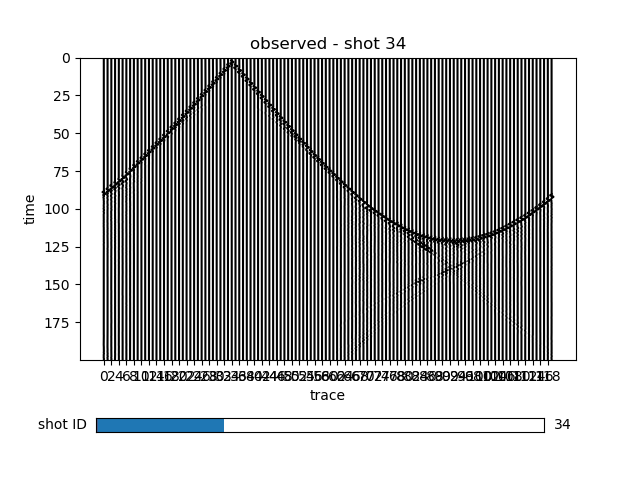

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [10]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [11]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [12]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [13]:
from stride import ProcessWavelets, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [14]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 4), block 1 (out of 2)
HEAD            Giving shot 3 to worker:0:0
HEAD            Giving shot 6 to worker:0:1
WORKER:0:1      (ShotID 6) Preparing to run state for shot
WORKER:0:0      (ShotID 3) Preparing to run state for shot
WORKER:0:1      (ShotID 6) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 6) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 3) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 6) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 3) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 6) Selected undersampling level 4
WORKER:0:0      (ShotID 3) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 6) Selected time stepping sc

WORKER:0:0      (ShotID 18) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 18) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 18) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 18) Selected undersampling level 4
WORKER:0:0      (ShotID 18) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 18) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.90 s
WORKER:0:1      Global performance: [OI=0.01, 22.88 GFlops/s, 0.62 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.85 s [OI=0.01, 24.26 GFlops/s, 0.66 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WOR

WORKER:0:1      (ShotID 30) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 30) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 30) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 30) Selected undersampling level 4
WORKER:0:1      (ShotID 30) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 30) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.33 s
WORKER:0:0      Global performance: [OI=0.01, 21.80 GFlops/s, 0.42 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.14 s [OI=0.01, 18.16 GFlops/s, 0.49 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=2.82, 0.67 GFlops/s, 0.02

WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 53.91 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 46) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 46
HEAD            Giving shot 79 to worker:0:1
WORKER:0:1      (ShotID 79) Preparing to run state for shot
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.29 s
WORKER:0:1      (ShotID 79) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 79) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 79) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 79) Selected undersampling level 4
WORKER:0:1      (ShotID 79) Selected time stepping scheme OT2
WORKER:0:0      Global performance: [OI=0.01, 15.99 GFlops/s, 0.44 GPts/s]
WORKER:0:0      Local performance:


WORKER:0:0        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 60.26 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 84) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 84
HEAD            Giving shot 100 to worker:0:0
WORKER:0:0      (ShotID 100) Preparing to run state for shot
WORKER:0:0      (ShotID 100) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 100) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 100) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 100) Selected undersampling level 4
WORKER:0:0      (ShotID 100) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 100) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` 

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.61 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 10) Completed state equation run for shot
HEAD            Functional value for shot 10: loss 2.366921e+00 for shot 10
WORKER:0:0      (ShotID 10) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 10) Running adjoint equation for shot
WORKER:0:1      Global performance: [OI=0.01, 15.05 GFlops/s, 0.41 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.27 s [OI=0.01, 16.27 GFlops/s, 0.44 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.04 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 36) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 36
HEAD            Giving shot 55 to worker:0:1
WORKER:0:1      (ShotID 55) Preparing to run state for shot
WORKER:0:1      (ShotID 55) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 55) Spatial grid spacing (0.500 mm | 4.054 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:1      (ShotID 55) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:1      (ShotID 55) Selected undersampling level 4
WORKER:0:1      (ShotID 55) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 55) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.96 s
WORKER:0:0      Global performance: [OI=0.01, 21.60 GFlops/s, 0.59 GPts/s]
WORK

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 57) Completed adjoint equation run for shot
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.39 s
HEAD            Retrieved gradient for shot 57
HEAD            Giving shot 65 to worker:0:0
WORKER:0:1      Global performance: [OI=0.01, 20.83 GFlops/s, 0.40 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.19 s [OI=0.01, 17.33 GFlops/s, 0.47 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.05 s [OI=2.82, 0.34 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 52.18 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 59) Completed adjoint equation run for shot
WORKER:0:0      (ShotID 65) Preparin

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.39 s [OI=0.01, 14.76 GFlops/s, 0.40 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.05 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.05 s [OI=3.17, 0.25 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 71) Completed state equation run for shot
HEAD            Functional value for shot 71: loss 2.309234e+00 for shot 71
WORKER:0:1      (ShotID 71) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 71) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.16 s
WORKER:0:0      Global performance: [OI=0.01, 25.01 GFlops/s, 0.48 GPts/

WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.04 s [OI=3.17, 0.35 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 117) Completed state equation run for shot
HEAD            Functional value for shot 117: loss 1.394809e+00 for shot 117
WORKER:0:0      (ShotID 117) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 117) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.67 s
WORKER:0:0      Global performance: [OI=0.01, 43.17 GFlops/s, 0.83 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.58 s [OI=0.01, 35.46 GFlops/s, 0.96 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.44 GFlop

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.03 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.88 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 21) Completed state equation run for shot
HEAD            Functional value for shot 21: loss 2.204172e+00 for shot 21
WORKER:0:0      (ShotID 21) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 21) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.16 s
WORKER:0:1      Global performance: [OI=0.01, 17.80 GFlops/s, 0.48 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.09 s [OI=0.01, 18.86 GFlops/s, 0.51 GPts/s]

WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.16 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 48.63 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 64) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 64
HEAD            Giving shot 72 to worker:0:1
WORKER:0:1      (ShotID 72) Preparing to run state for shot
WORKER:0:1      (ShotID 72) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 72) Spatial grid spacing (0.500 mm | 4.053 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:1      (ShotID 72) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:1      (ShotID 72) Selected undersampling level 4
WORKER:0:1      (ShotID 72) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 72) Runni

WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.04 s [OI=2.82, 0.37 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 52.23 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 86) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 86
HEAD            Giving shot 93 to worker:0:0
WORKER:0:0      (ShotID 93) Preparing to run state for shot
WORKER:0:0      (ShotID 93) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 93) Spatial grid spacing (0.500 mm | 4.053 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:0      (ShotID 93) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:0      (ShotID 93) Selected undersampling level 4
WORKER:0:0      (ShotID 93) Selected time stepping scheme OT2
WORKER:0:1      Operator `acousti

WORKER:0:0      (ShotID 106) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.15 s
WORKER:0:1      Global performance: [OI=0.01, 17.97 GFlops/s, 0.49 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.10 s [OI=0.01, 18.78 GFlops/s, 0.51 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.69 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 109) Completed state equation run for shot
HEAD            Functional value for shot 109: loss 1.636367e+00 for shot 109
WORKER:0:1      (ShotID 109) Preparing to run adjoint for

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.45 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 32) Completed state equation run for shot
HEAD            Functional value for shot 32: loss 2.603780e+00 for shot 32
WORKER:0:1      (ShotID 32) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 32) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.98 s
WORKER:0:0      Global performance: [OI=0.01, 29.70 GFlops/s, 0.57 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.84 s [OI=0.01, 24.46 GFlops/s, 0.66 GPts/

WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.43 s
WORKER:0:0      Global performance: [OI=0.01, 14.38 GFlops/s, 0.39 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.33 s [OI=0.01, 15.52 GFlops/s, 0.42 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.04 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=3.17, 0.41 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 52) Completed state equation run for shot
HEAD            Functional value for shot 52: loss 1.229718e+00 for shot 52
WORKER:0:0      (ShotID 52) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 52) Running adjoint equation for shot

WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.26 s
WORKER:0:0      Global performance: [OI=0.01, 22.96 GFlops/s, 0.45 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.04 s [OI=0.01, 19.83 GFlops/s, 0.54 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.78 GFlops/s, 0.02 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.21 s [OI=0.94, 40.89 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 58) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 58
HEAD            Giving shot 70 to worker:0:0
WORKER:0:0      (ShotID 70) Preparing to run state for shot
WORKER:0:0      (ShotID 70) Estimated bandwidth for the propagated wavelet 0.255-0.73

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.07 s
WORKER:0:1      Global performance: [OI=0.01, 27.00 GFlops/s, 0.52 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.92 s [OI=0.01, 22.37 GFlops/s, 0.61 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.21 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.14 s [OI=0.94, 59.76 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 87) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 87
HEAD            Giving shot 90 to worker:0:1
WORKER:0:1      (ShotID 90) Preparing to run state for shot
WORKER:0:1      (ShotID 90) Estimated bandwidth for the propagated wavelet 0.255-0.73

WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.73 s [OI=0.01, 28.20 GFlops/s, 0.76 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.12 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.09 s [OI=0.94, 94.79 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 119) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 119
HEAD            Updating variable vp,
HEAD            	 grad before processing in range [-4.554362e+02, 1.586987e+02]
HEAD            	 grad after processing in range [-1.000000e+00, 3.483188e-01]
HEAD            	 variable range before update [1.485850e+03, 1.517500e+03]
HEAD            	 variable range after update [1.484414e+03, 1.523670e+03]
HEAD            Done iteration 

WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.23 s
WORKER:0:0      Global performance: [OI=0.01, 16.80 GFlops/s, 0.46 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.10 s [OI=0.01, 18.77 GFlops/s, 0.51 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.04 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.05 s [OI=3.17, 0.24 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 25) Completed state equation run for shot
HEAD            Functional value for shot 25: loss 2.249323e+00 for shot 25
WORKER:0:0      (ShotID 25) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 25) Running adjoint equation for shot

WORKER:0:0      (ShotID 61) Spatial grid spacing (0.500 mm | 4.039 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:0      (ShotID 61) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:0      (ShotID 61) Selected undersampling level 4
WORKER:0:0      (ShotID 61) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 61) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.91 s
WORKER:0:1      Global performance: [OI=0.01, 22.67 GFlops/s, 0.62 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.85 s [OI=0.01, 24.31 GFlops/s, 0.66 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

WORKER:0:1      (ShotID 83) Selected time stepping scheme OT2
HEAD            Functional value for shot 81: loss 2.058399e+00 for shot 81
WORKER:0:0      (ShotID 81) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 81) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 83) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.06 s
WORKER:0:0      Global performance: [OI=0.01, 27.29 GFlops/s, 0.53 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.90 s [OI=0.01, 22.98 GFlops/s, 0.62 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.06 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.16 s [OI=0.94, 55.22 GFlops/s]
WORKER:0:0      Performa

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 107) Completed state equation run for shot
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.21 s
HEAD            Functional value for shot 107: loss 1.249999e+00 for shot 107
WORKER:0:0      (ShotID 107) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 107) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 23.98 GFlops/s, 0.46 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.03 s [OI=0.01, 20.01 GFlops/s, 0.54 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.05 s [OI=2.82, 0.29 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.13 s [OI=0.94, 64.39 GFlops/s]
WORKER:0:1      Performance[mode=a

WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.76 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.89 s
WORKER:0:1      Global performance: [OI=0.01, 16.45 GFlops/s, 0.32 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.45 s [OI=0.01, 14.25 GFlops/s, 0.39 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.07 s [OI=2.82, 0.21 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.25 s [OI=0.94, 33.54 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 17) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 17
HEAD            Giving shot 20 to worker:0:1
WORKER:0:1      (ShotID 20) Preparing to run state for shot
WORKER:0:0      Global performance: [OI=0.01, 15.33 GFlops/s, 0.30 GPts/s]
WO

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 29) Completed state equation run for shot
HEAD            Functional value for shot 29: loss 1.820594e+00 for shot 29
WORKER:0:1      (ShotID 29) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 29) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.22 s
WORKER:0:0      Global performance: [OI=0.01, 16.91 GFlops/s, 0.46 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.14 s [OI=0.01, 18.14 GFlops/s, 0.49 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.03 s [OI=3.17, 0.47 GFlops/s]

HEAD            Retrieved gradient for shot 48
HEAD            Giving shot 73 to worker:0:0
WORKER:0:0      (ShotID 73) Preparing to run state for shot
WORKER:0:1      (ShotID 63) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 73) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 73) Spatial grid spacing (0.500 mm | 4.028 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:0      (ShotID 73) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 73) Selected undersampling level 4
WORKER:0:0      (ShotID 73) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 73) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.81 s
WORKER:0:1      Global performance: [OI=0.01, 25.39 GFlops/s, 0.69 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        

WORKER:0:1      (ShotID 82) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 82
HEAD            Giving shot 97 to worker:0:1
WORKER:0:1      (ShotID 97) Preparing to run state for shot
WORKER:0:1      (ShotID 97) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 97) Spatial grid spacing (0.500 mm | 4.028 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:1      (ShotID 97) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:1      (ShotID 97) Selected undersampling level 4
WORKER:0:1      (ShotID 97) Selected time stepping scheme OT2
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.12 s
WORKER:0:1      (ShotID 97) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 25.90 GFlops/s, 0.50 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<249

HEAD            	 grad after processing in range [-1.000000e+00, 2.623709e-01]
HEAD            	 variable range before update [1.480452e+03, 1.526197e+03]
HEAD            	 variable range after update [1.480841e+03, 1.531397e+03]
HEAD            Done iteration 2 (out of 4), block 2 (out of 2) - Total loss_freq 2.216460e+01
HEAD            ====================================================================
HEAD            Starting iteration 3 (out of 4), block 2 (out of 2)
HEAD            Giving shot 2 to worker:0:0
HEAD            Giving shot 12 to worker:0:1
WORKER:0:0      (ShotID 2) Preparing to run state for shot
WORKER:0:1      (ShotID 12) Preparing to run state for shot
WORKER:0:1      (ShotID 12) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 12) Spatial grid spacing (0.500 mm | 4.029 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:1      (ShotID 12) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WOR

WORKER:0:1      (ShotID 28) Completed state equation run for shot
HEAD            Functional value for shot 28: loss 2.059715e+00 for shot 28
WORKER:0:1      (ShotID 28) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 28) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.53 s
WORKER:0:0      Global performance: [OI=0.01, 18.89 GFlops/s, 0.37 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.29 s [OI=0.01, 16.03 GFlops/s, 0.44 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.04 s [OI=2.82, 0.45 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.22 s [OI=0.94, 38.56 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 24) Completed a

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 1.05 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 40) Completed state equation run for shot
HEAD            Functional value for shot 40: loss 1.260568e+00 for shot 40
WORKER:0:0      (ShotID 40) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 40) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.20 s
WORKER:0:1      Global performance: [OI=0.01, 17.22 GFlops/s, 0.47 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.13 s [OI=0.01, 18.26 GFlops/s, 0.50 GPts/s]

WORKER:0:1        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 50.71 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 75) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 75
HEAD            Giving shot 96 to worker:0:1
WORKER:0:1      (ShotID 96) Preparing to run state for shot
WORKER:0:1      (ShotID 96) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 96) Spatial grid spacing (0.500 mm | 4.029 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:1      (ShotID 96) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:1      (ShotID 96) Selected undersampling level 4
WORKER:0:1      (ShotID 96) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 80) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 96) Running state equation for s

WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.83 GFlops/s, 0.02 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.15 s [OI=0.94, 58.40 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 108) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 108
HEAD            Giving shot 118 to worker:0:0
WORKER:0:0      (ShotID 118) Preparing to run state for shot
WORKER:0:0      (ShotID 118) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 118) Spatial grid spacing (0.500 mm | 4.029 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:0      (ShotID 118) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 118) Selected undersampling level 4
WORKER:0:0      (ShotID 118) Selected time stepping scheme OT2
WORKER:0:1      Operator

HEAD            Retrieved gradient for shot 5
HEAD            Giving shot 14 to worker:0:0
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.38 s
WORKER:0:0      (ShotID 14) Preparing to run state for shot
WORKER:0:1      Global performance: [OI=0.01, 21.00 GFlops/s, 0.41 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.10 s [OI=0.01, 18.79 GFlops/s, 0.51 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.04 s [OI=2.82, 0.34 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.25 s [OI=0.94, 34.55 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 13) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 13
HEAD            Giving shot 15 to worker:0:1
WORKER:0:1      (ShotID 15) Preparing to run sta

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.01 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.51 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 49) Completed state equation run for shot
HEAD            Functional value for shot 49: loss 1.395744e+00 for shot 49
WORKER:0:1      (ShotID 49) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 49) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.01 s
WORKER:0:0      Global performance: [OI=0.01, 28.80 GFlops/s, 0.56 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.84 s [OI=0.01, 24.62 GFlops/s, 0.67 GPts/

WORKER:0:1      (ShotID 76) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.00 s
WORKER:0:0      Global performance: [OI=0.01, 20.64 GFlops/s, 0.56 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.94 s [OI=0.01, 21.86 GFlops/s, 0.59 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 1.09 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 74) Completed state equation run for shot
HEAD            Functional value for shot 74: loss 1.456638e+00 for shot 74
WORKER:0:0      (ShotID 74) Preparing to run adjoint for shot
W

WORKER:0:0      (ShotID 103) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.33 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.96 s
WORKER:0:1      Global performance: [OI=0.01, 21.70 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.14 s [OI=0.01, 18.07 GFlops/s, 0.49 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.88 GFlops/s, 0.02 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 46.73 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 101) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 101
HEAD            Giving shot 111 to worker:0:1
WORKER:0:0      Globa

<IPython.core.display.Javascript object>


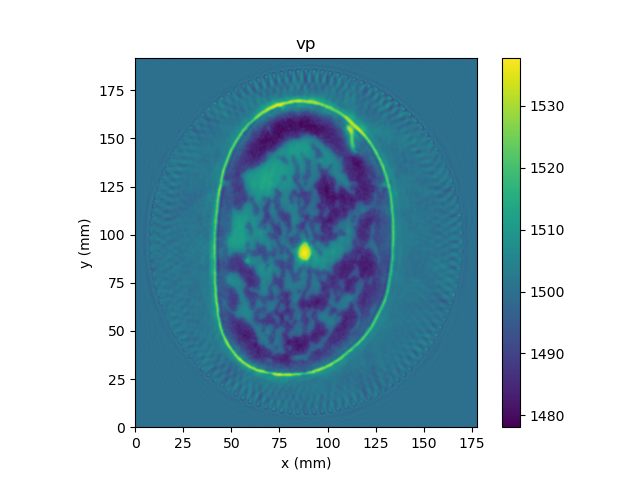

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [15]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, f_min=f_min, f_max=f_max, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_min=f_min, f_max=f_max, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [16]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss_freq,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_min=0.05e6, f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [17]:
await mosaic.interactive('off')